# 1. Introduction

In the second part of our series, we will learn about arguably one of the most important part of conducting survival analysis: characterizing the time-dependence of covariate effects on the probability of the event of interest happening at a given time, which is called **hazard**. 

Whether it be patient death or equipment failure, we are interested in identifying factors that increase or decrease the probability of the event occurring, using a subset of approaches called **survival regression**. However, this is not simply a yes or no question, as often the contribution of a factor can and does change with time. For example, there is [evidence](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-10-20#annotations:rtZ5zqMrEemcqH-JlwEa1A) that the status of hormone receptors increase the risk of breast cancer metastases during the early stages of the disease, but becomes protective later on. Authors of the study suggested that this reversal may account for previous conventional survival regressions (which did not account for time-dependent effects) not finding the status of hormone receptors to be a significant factor in breast cancer metastases.

One of the most commonly used models for survival regression is the Cox proportional hazards model, which has the assumption that the factors under examination have the same effect on hazard at any point in time. If the data in question does not satisfy the **proportional hazards assumption**, which is very likely given the complexity of real-life conditions, results of the Cox's model cannot be trusted. Nevertheless, determining which factors have time-varying effects can be quite useful in itself in terms of gaining insights into the data.

If you just landed here, please check out the first part of this series under the "Files" tab for a better introduction to survival analysis.

Let's get started!

# 2. Import and preprocess data

Here we will use the same IBM Telco customer churn dataset used in part 1 of this series. We will use label encoding to quickly convert categorical variables to numerical encoding, as required by the `lifelines` package:

In [16]:
## Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

## Import data
df = pd.read_csv("https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv")

## Label encode categorical features 
cat_col = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 
           'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

le = LabelEncoder()

df[cat_col] = df[cat_col].apply(le.fit_transform)

# 3. Test the proportional hazards assumption

## 3.1 Using Schoenfeld residuals

One of the most commonly used methods to test the proportional hazards assumption is based on scaled Schoenfeld residuals, which is independent of time if the assumption holds. Therefore, for any given covariate, a significant relationship between the Schoenfeld residuals and time indicates its effect on hazard is time-dependent.

First up, we will use the Python package `lifelines` to calculate and plot scaled Schoenfeld residuals again various transformations of time for each input variable:

In [37]:
%matplotlib inline

## Import libraries
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

## Instantiate object
cph = CoxPHFitter()

## Fit to data
cph.fit(df, 'Tenure', 'Churn', show_progress=False)

## Test assumption
results = proportional_hazard_test(cph, df, time_transform='rank')

## Output results
lifelines_res = results.summary

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                       test_statistic      p  -log2(p)
Contract         km            195.22 <0.005    144.96
                 rank          175.17 <0.005    130.42
Dependents       km              0.05   0.82      0.29
                 rank            0.10   0.75      0.41
DeviceProtection km              3.66   0.06      4.16
                 rank            3.84   0.05      4.32
Gender           km              0.01   0.92      0.11
                 rank            0.18   0.67      0.58
InternetService  km             57.51 <0.005     44.76
                 rank           65.14 <0.005     50.35
MonthlyCharges   km            314.91 <0.005    231.64
                 rank          398.86 <0.005    292.36
MultipleLines    km              2.88   0.09      3.48
                 rank            0.85   0.36      1.49
OnlineBackup     km              1.37 

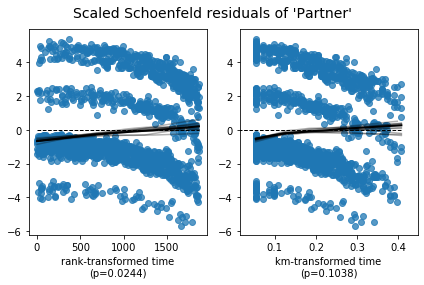

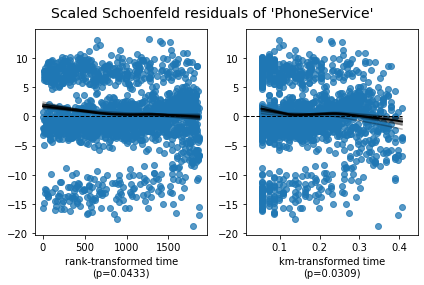

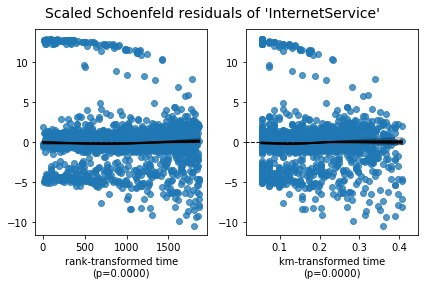

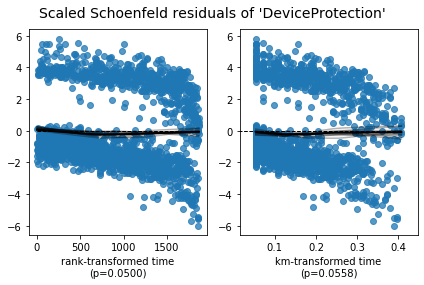

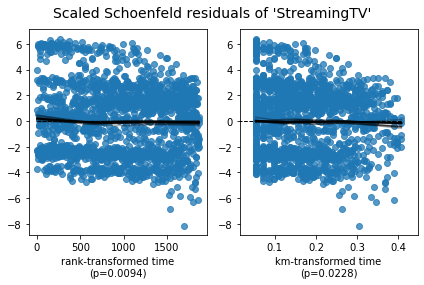

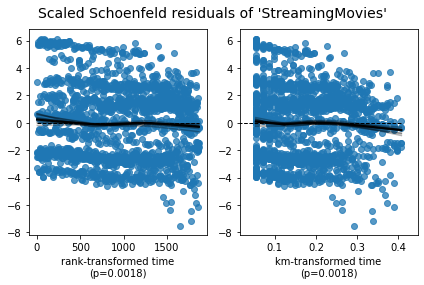

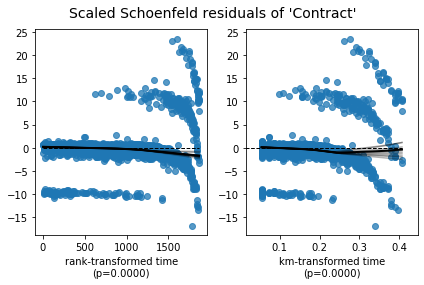

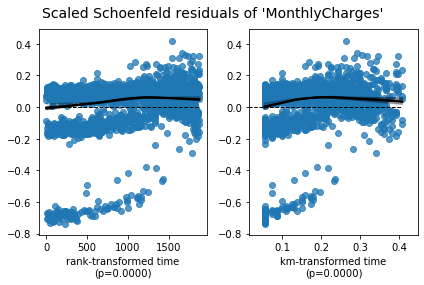

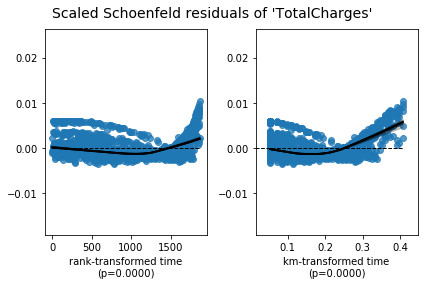

In [17]:
## Plot scaled Schoenfeld residuals
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True, advice=False)

We see that many aspects of customer characteristics and purchasing behaviour have time-dependent effects on their tendency to leave the company. This is consistent with the non-constant rate of change in the survival curves seen in the [first post of this series](https://kyso.io/nd823/survival-analysis/file/1.%20Survival%20functions.ipynb).

Sticking with our system of aggregating insights from multiple packages and approaches, let's see what results we get using the R package `survival`, which also examines the relationship between scaled Schoenfeld residuals and time for each variable:

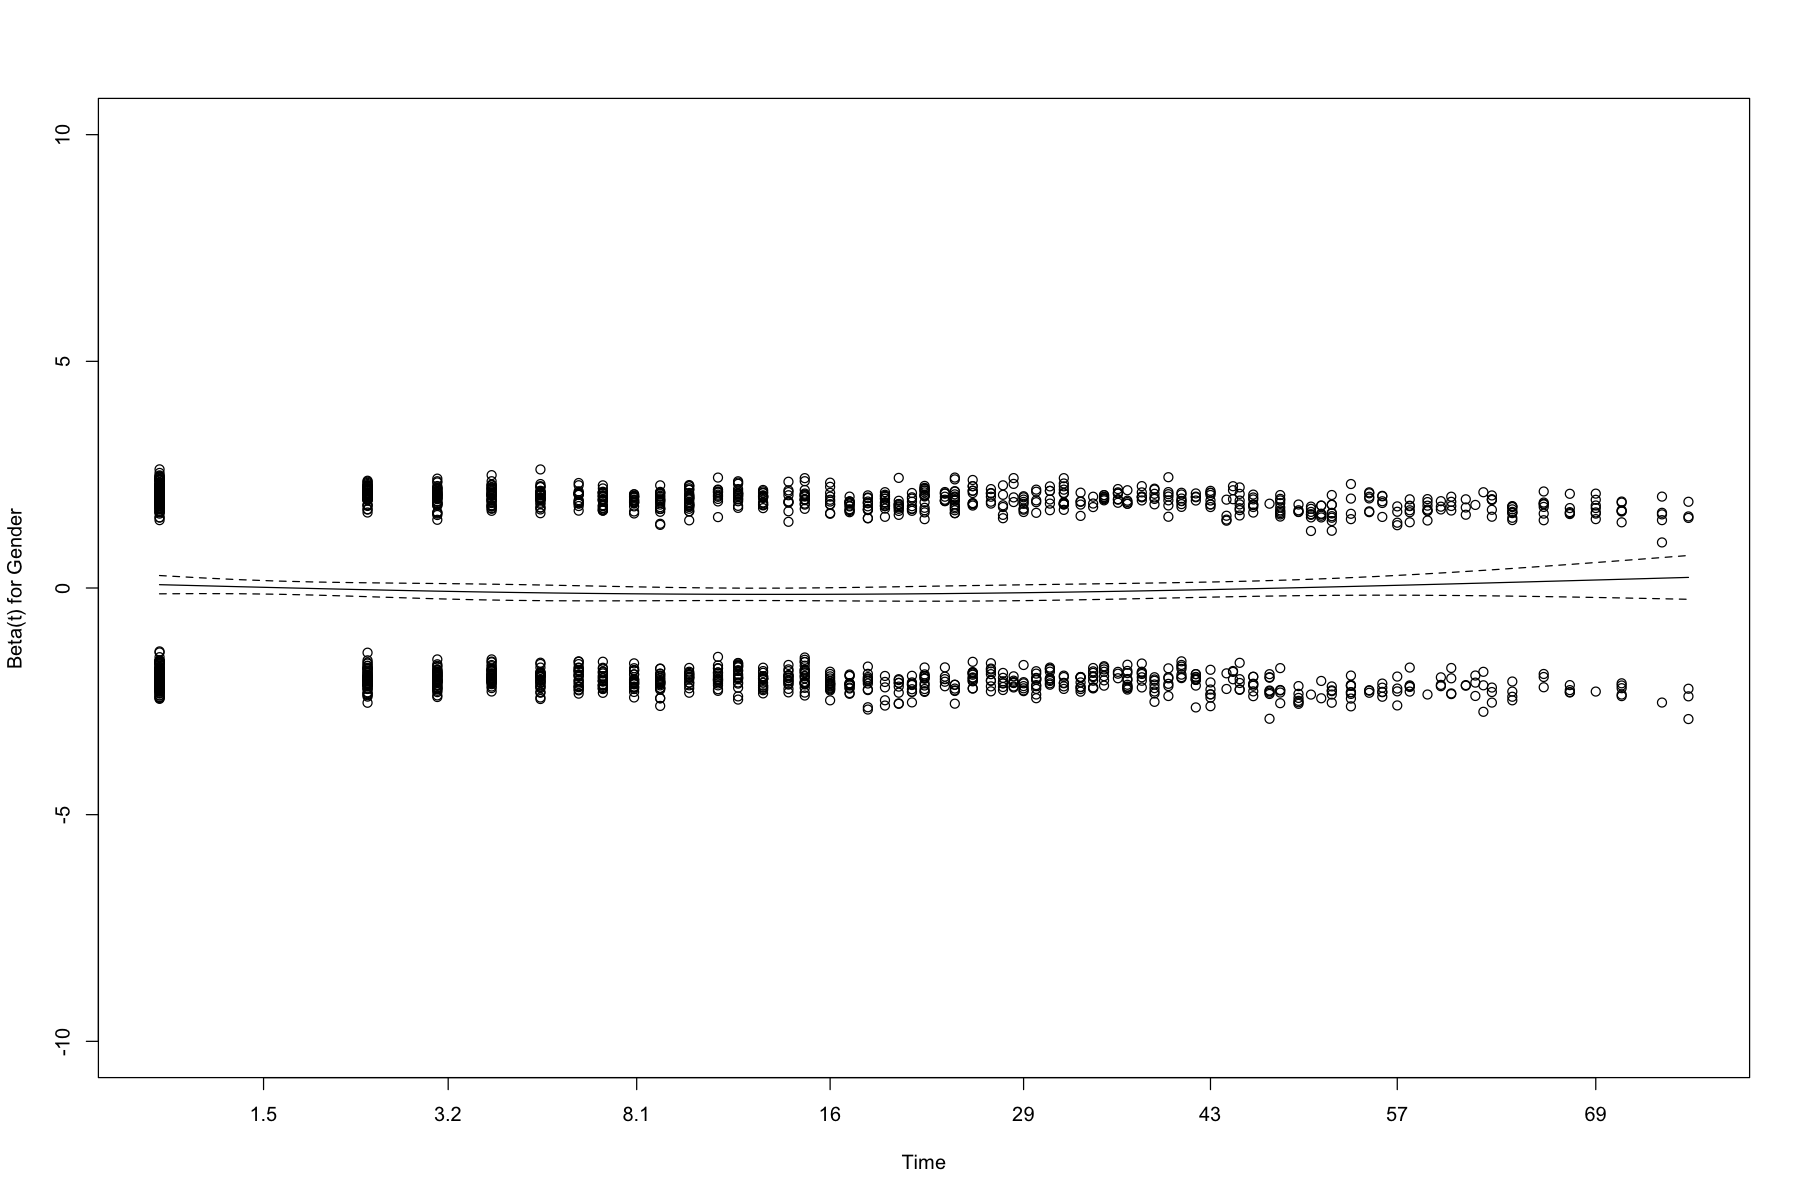

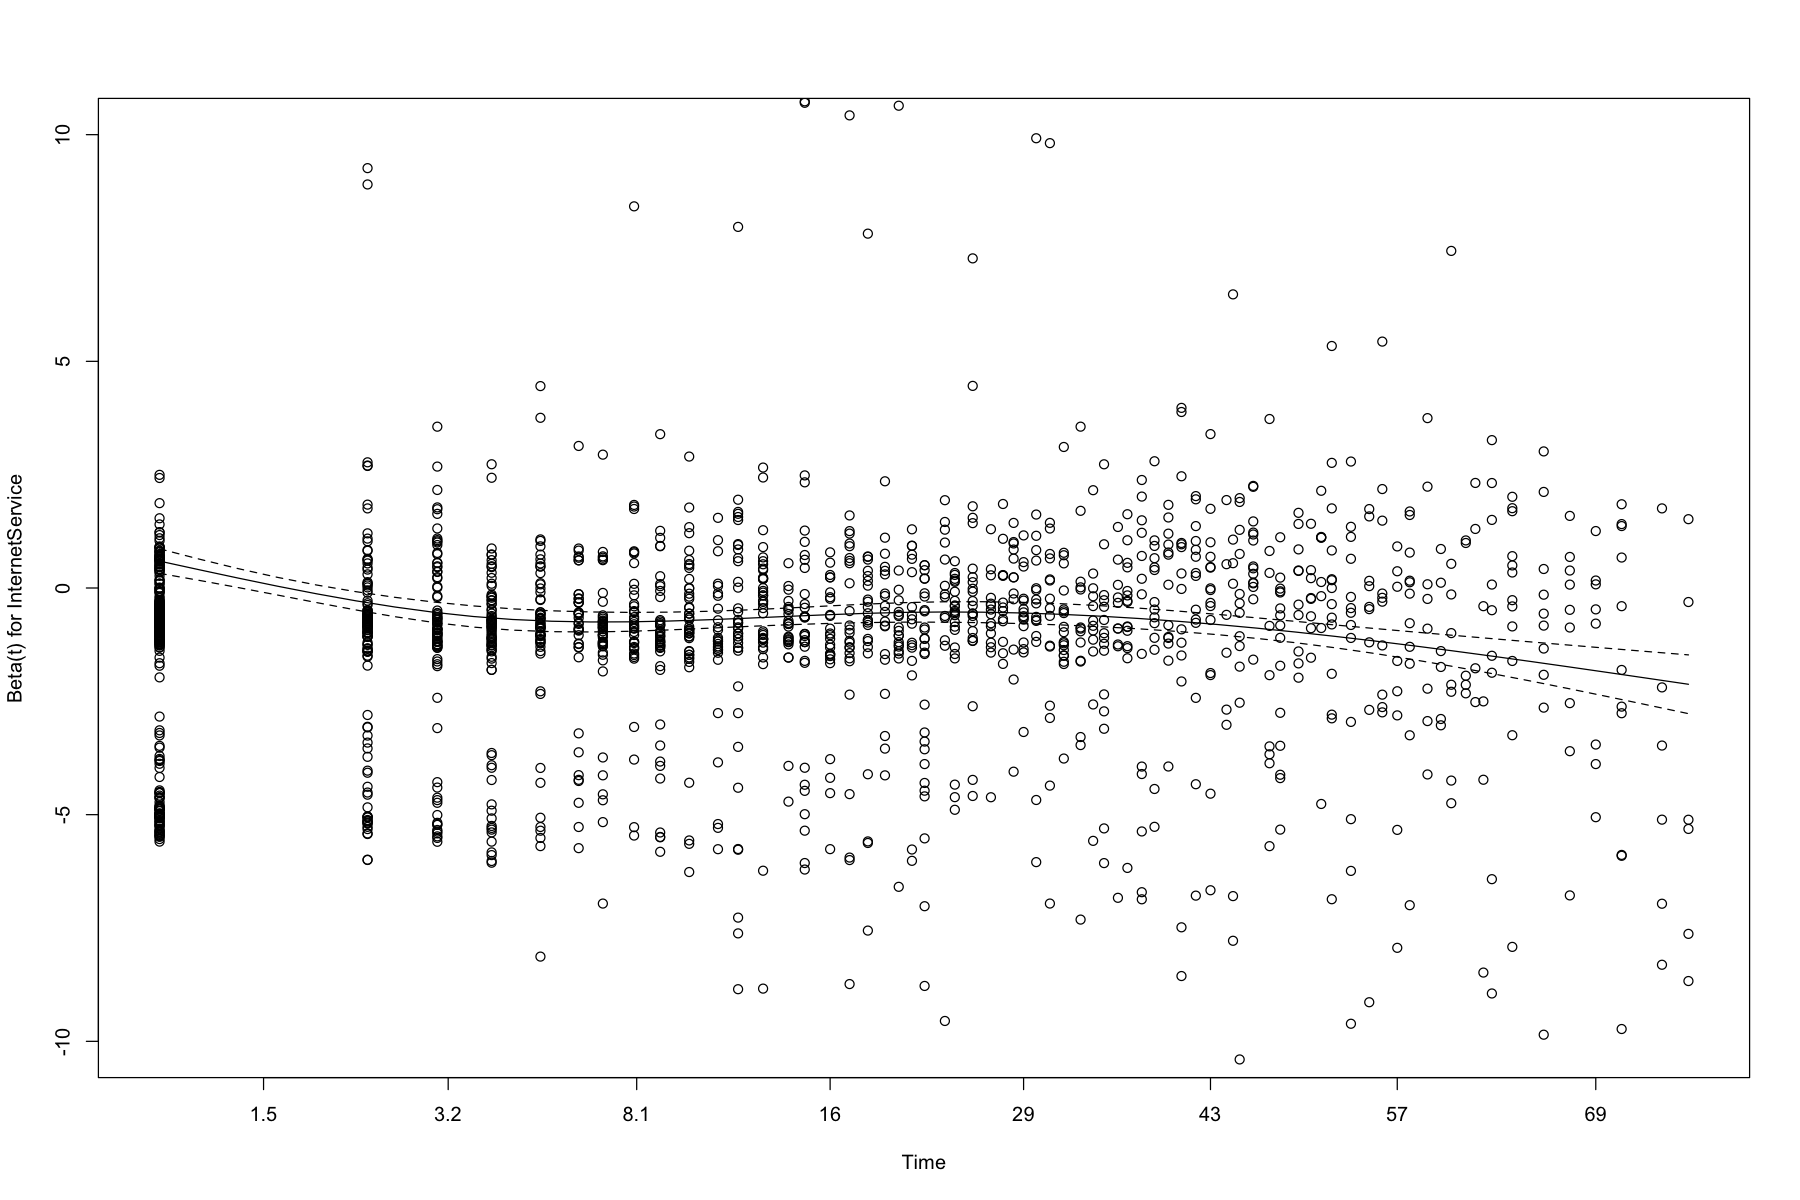

In [38]:
%get --from Python3 df

## Impor library
library(survival)

## Test proportional hazard assumption
cox <- coxph(Surv(Tenure, Churn) ~  ., data = df)

x <- cox.zph(cox, transform="km", global=TRUE)

## Output results
survival_stats <- as.data.frame(x$table)

## Plot selected variables as example
options(repr.plot.width=15, repr.plot.height=10)

plot(x[c(1, 7)], ylim=c(-10, 10))

Picking `Gender` and `InternetService` as examples on the two extremes, the former satisfying the proportional hazards assumption and the latter violating it, we get a more closer look at what a random vs significant relationship between scaled Schoenfeld residuals and time.

As we have done before, we will save the results from each method for a comparison at the end of the post.

# 4. Compare results from `lifelines` and `survival`

Let's compare the statistical significance, in terms of p-values, of the relationship between scaled Schoenfeld residuals and time for each variable as calculated by the two packages. Once again, we use the balloon plot to represent p-values for each variable:

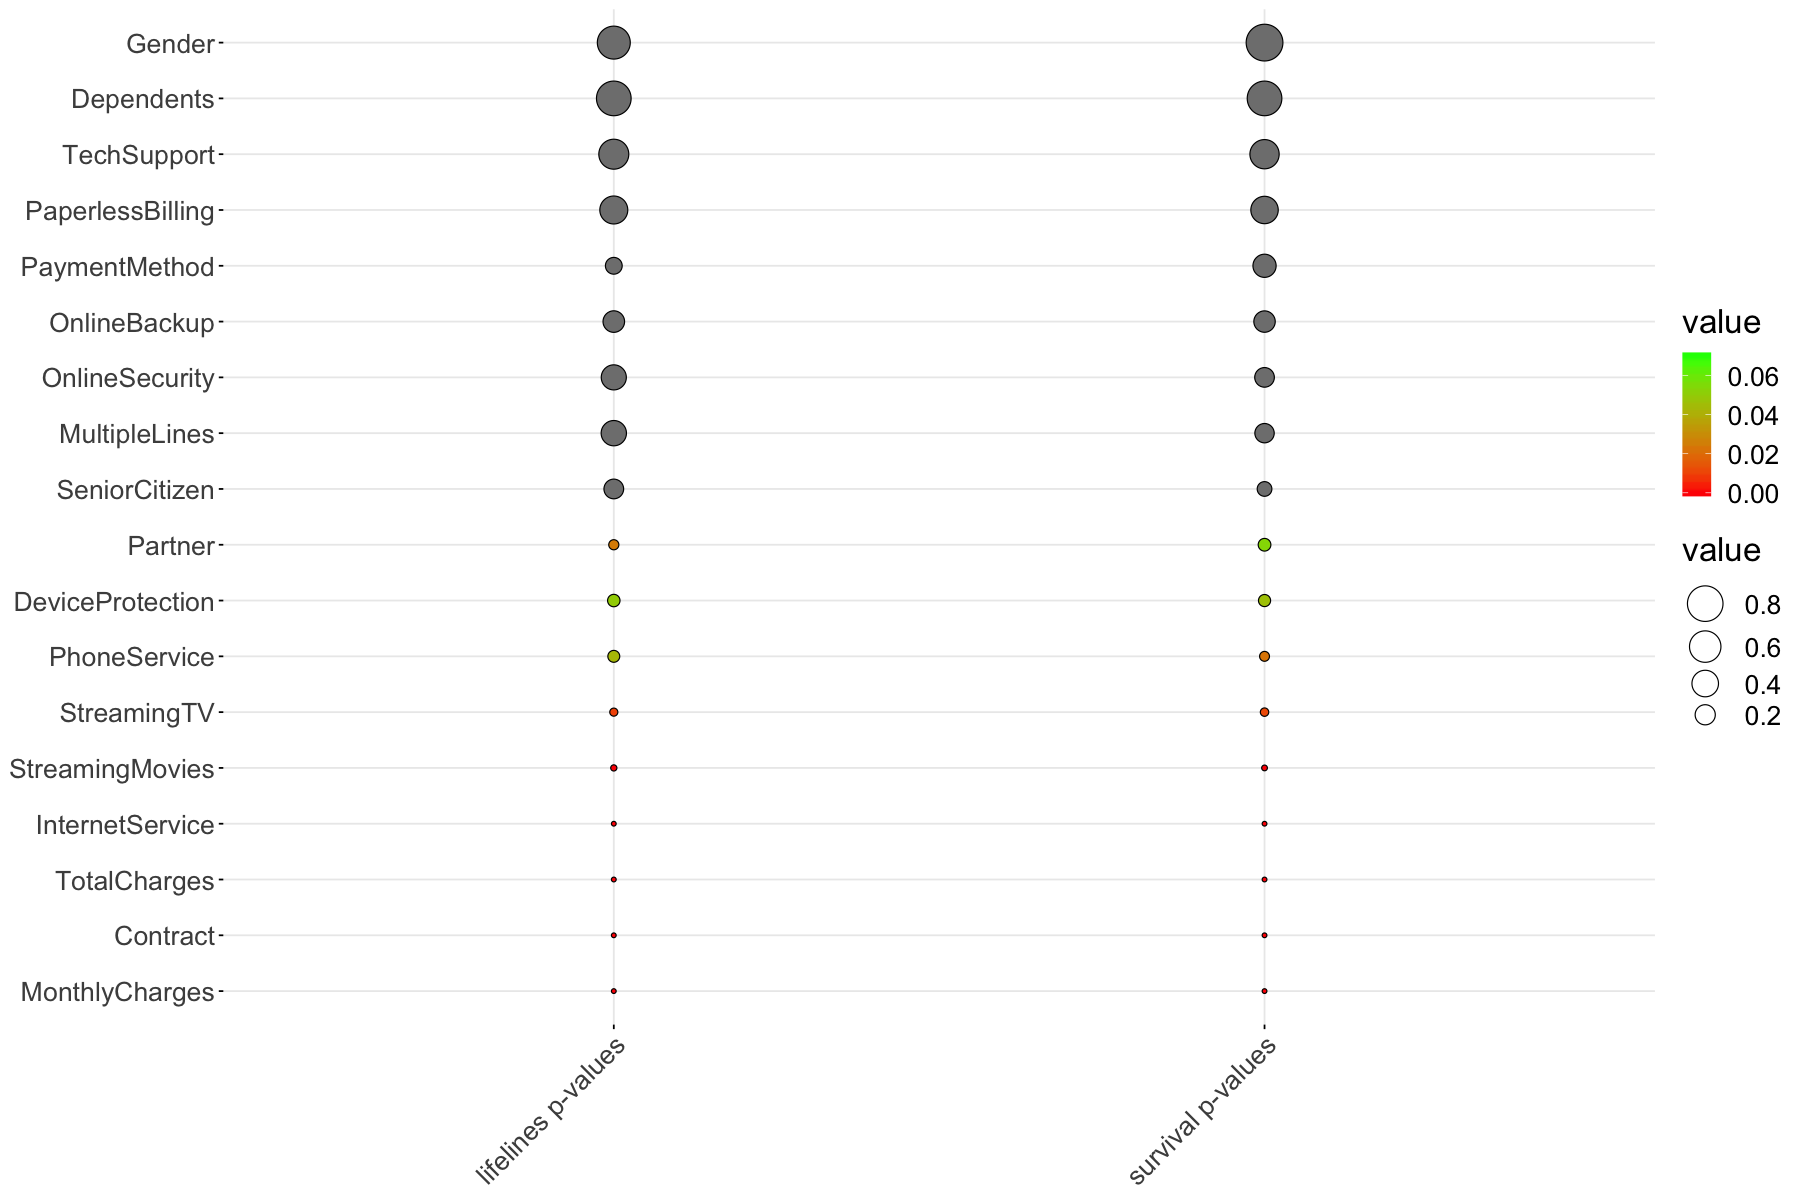

In [47]:
%get --from Python3 lifelines_res

## Import libraries
library(ggplot2)
library(ggpubr)

## Convert rownames to a variable column
lifelines_res$var <- rownames(lifelines_res)

rownames(lifelines_res) <- NULL

survival_stats$var <- rownames(survival_stats)

rownames(survival_stats) <- NULL

## Select only relevant columns from each results dataframe
lifelines_res <- lifelines_res[, c('var', 'p')]

survival_stats <- survival_stats[, c('var', 'p')]

## Rename column headers
colnames(lifelines_res) <- c('var', 'lifelines p-values')

colnames(survival_stats) <- c('var', 'survival p-values')

## Merge dataframes for comparison
merged_df <- Reduce(merge, list(lifelines_res, survival_stats))

rownames(merged_df) <- merged_df$var

merged_df$var <- NULL

## Sort by one of the columns for comparison
merged_df <- merged_df[order(-merged_df['survival p-values']), ] 

## Make balloon plot of dataframe
ggballoonplot(merged_df, fill = "value") + 
      scale_fill_gradient(low = "red", high = "green", limits=c(0, 0.07)) +
        theme(text = element_text(size=20))

Unsuprisingly, the two packages identified the same set of time-varying variables (ones at the bottom represented by very small and red-coloured cirlces). I will try to update this post if I find other methods for characterizing time-dependent effects of covariates, so we can have a more meaningful comparison.

In the next few posts, we will explore methods to deal with variables that violate the proportional hazard assumption, including stratification, discretizing continuous variables and introducing time-varying covariates, in addition to the Aalen additive model that does away with the proportional hazards assumption entirely.

As always, any questions and suggestions are very welcome!

Til next time! :)